1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
from scipy.interpolate import UnivariateSpline
from scipy import optimize, fftpack, signal

Array of maximum wind speed measurements over 21 years:
 [28.09 22.46 26.65 26.65 28.79 30.19 26.19 26.75 23.34 24.16 29.75 27.93
 26.68 23.85 32.97 25.79 26.37 25.28 26.73 23.2  26.76]

Maximum wind speed prediction in 50 years: 35.68916347355421


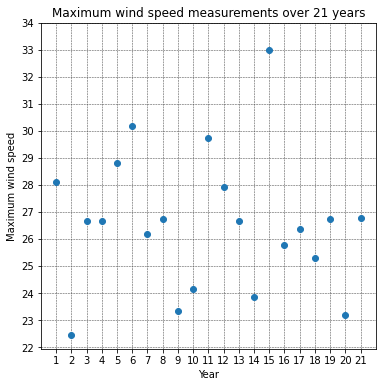

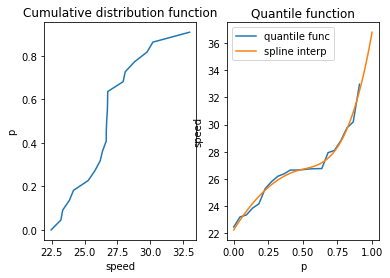

In [58]:
max_speeds = np.load('max-speeds.npy')
print('Array of maximum wind speed measurements over 21 years:\n', max_speeds)
years_nb = max_speeds.shape[0]
#print(years_nb)
X = np.arange(1, years_nb+1)
#print(X)
plt.figure(figsize=(6, 6))
plt.plot(X, max_speeds, 'o', ms=6, label='measures')
plt.title('Maximum wind speed measurements over 21 years')
plt.xlabel('Year')
plt.ylabel('Maximum wind speed')
plt.xticks(X)
plt.yticks(np.arange(22, 35))
plt.grid(linestyle="--", linewidth=0.5, color='.25')

max_speeds = np.sort(max_speeds)
p = 1. * np.arange(years_nb) / (years_nb + 1)
fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
ax1.plot(max_speeds, p)
ax1.set_title('Cumulative distribution function')
ax1.set_xlabel('speed')
ax1.set_ylabel('p')

ax2 = fig1.add_subplot(122)
ax2.plot(p, max_speeds, label='quantile func')
ax2.set_title('Quantile function')
ax2.set_xlabel('p')
ax2.set_ylabel('speed')
spl = UnivariateSpline(p, max_speeds, bbox=[0, 1])
spl.set_smoothing_factor(2) #Adjust manually this factor to obtain a better spline
interpolation_time = np.linspace(0, 1, 100)
quantile_func = spl(interpolation_time)
ax2.plot(interpolation_time, quantile_func, label='spline interp')
ax2.legend(loc='best')

fifty_prob = 1. - 0.02
m_val = abs(fifty_prob-interpolation_time[0])
c = -1
for val in interpolation_time:
    c += 1
    if abs(fifty_prob-val) < m_val:
        m_val = abs(fifty_prob-val)
        m_index = c
print('\nMaximum wind speed prediction in 50 years:', quantile_func[m_index])

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Fit of maximum temperatures:
Parameters:
 [10.5454  0.5824 27.7635]
Covariance matrix:
 [[ 0.4327 -0.0021  0.0101]
 [-0.0021  0.001   0.0142]
 [ 0.0101  0.0142  0.4363]]


Fit of minimum temperatures:
Parameters:
 [ 24.9635  -0.6086 -36.4327]
Covariance matrix:
 [[ 1.8738e+00 -5.0204e-04  2.5731e-01]
 [-5.0204e-04  6.2386e-04 -1.8175e-02]
 [ 2.5731e-01 -1.8175e-02  1.5616e+00]]

The fits lead to a reasonable result both because of the entries in the covariance matrixes, but also because it's very likely that temperatures can be described by a periodic function over the years

Estimation of the position of the maximum for the maximum temperatures fit: -0.006006006006005649
Estimation of the half-period of the fit function for maximum temperatures: 5.393393393393394 months. So approximately: 5 months and 11 days
Estimation of the position of the maximum for the minimum temperatures fit: -0.006006006006005649
Estimation of the half-period of the fit function for minimum temperatures: 5.15

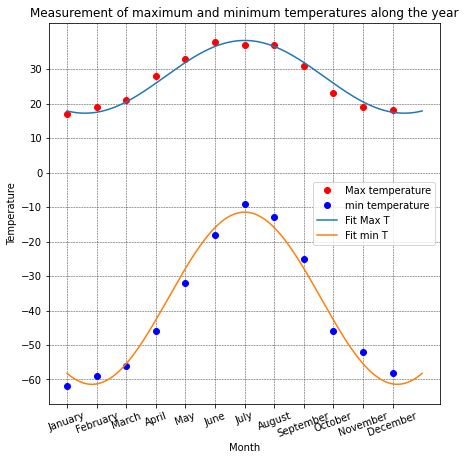

In [50]:
d = {'max': [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18], 'min': [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]}
df = pd.DataFrame(data=d)
df

plt.figure(figsize=(7, 7))
plt.plot(np.arange(-6, 6), df['max'], 'ro', label='Max temperature')
plt.plot(np.arange(-6, 6), df['min'], 'bo', label='min temperature')
plt.title('Measurement of maximum and minimum temperatures along the year')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.xticks(np.arange(-6, 6), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=20)
plt.yticks(np.arange(-70, 40, 10))
plt.grid(linestyle="--", linewidth=0.5, color='.25')

#Cosinus function that could describe the data
def f(x, a, b, c):
    return (a*np.cos(b*x))+c

M_par, M_cov = optimize.curve_fit(f, np.arange(-6, 6), df['max'], p0=[10.5, 0.6, 27.8])
print("Fit of maximum temperatures:")
print("Parameters:\n", M_par)
print("Covariance matrix:\n", M_cov)
print('\n')
m_par, m_cov = optimize.curve_fit(f, np.arange(-6, 6), df['min'], p0=[25, -0.6, -36])
print("Fit of minimum temperatures:")
print("Parameters:\n", m_par)
print("Covariance matrix:\n", m_cov)

X = np.linspace(-6, 6, 1000)
plt.plot(X, f(X, M_par[0], M_par[1], M_par[2]), label='Fit Max T')
plt.plot(X, f(X, m_par[0], m_par[1], m_par[2]), label='Fit min T')
plt.legend(loc='best')

print("\nThe fits lead to a reasonable result both because of the entries in the covariance matrixes, but also because it's very likely that temperatures can be described by a periodic function over the years\n")
half_t_M = abs(X[np.argmin(f(X, M_par[0], M_par[1], M_par[2]))]-X[np.argmax(f(X, M_par[0], M_par[1], M_par[2]))])
center_M = X[np.argmax(f(X, M_par[0], M_par[1], M_par[2]))]
print("Estimation of the position of the maximum for the maximum temperatures fit:", center_M)
print("Estimation of the half-period of the fit function for maximum temperatures:", half_t_M, "months. So approximately:", int(np.modf(half_t_M)[1]), "months and", int(np.modf(half_t_M)[0]*30), "days")
half_t_m = abs(X[np.argmin(f(X, m_par[0], m_par[1], m_par[2]))]-X[np.argmax(f(X, m_par[0], m_par[1], m_par[2]))])
center_m = X[np.argmax(f(X, m_par[0], m_par[1], m_par[2]))]
print("Estimation of the position of the maximum for the minimum temperatures fit:", center_m)
print("Estimation of the half-period of the fit function for minimum temperatures:", half_t_m, "months. So approximately:", int(np.modf(half_t_m)[1]), "months and", int(np.modf(half_t_m)[0]*30), "days")
print("The positions of the maximum coincide in time, but semiperiods of the fits are nearer to 5 months than to 6 months, which is the semiperiod of a normal year. Besides semiperiods of the fits differ one from the other for", abs(half_t_M-half_t_m), "months, so approximately", int(np.modf(abs(half_t_M-half_t_m))[0]*30), "days.")
print("This time offset could be acceptable within the fit accuracity if one intends to represent monthly the extreme temperatures of a single year")

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


First local minimum:
      fun: -0.21546382438350387
     jac: array([2.7418e-06, 1.4156e-07])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 4
    njev: 10
  status: 0
 success: True
       x: array([-1.7036,  0.7961]) 

Second local minimum:
      fun: -0.21546382281024845
     jac: array([ 4.4142e-05, -2.5880e-04])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 93
     nit: 7
  status: 1
 success: True
       x: array([ 1.7036, -0.7961]) 

First global minimum:
    direc: array([[1., 0.],
       [0., 1.]])
     fun: -1.0316284492762329
 message: 'Optimization terminated successfully.'
    nfev: 34
     nit: 2
  status: 0
 success: True
       x: array([-0.0899,  0.7126]) 

Second global minimum:
       fun: -1.0316284534898772
 hess_inv: array([[ 0.1293, -0.0081],
       [-0.0081,  0.0624]])
      jac: array([ 1.4901e-08, -1.6391e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: Tr

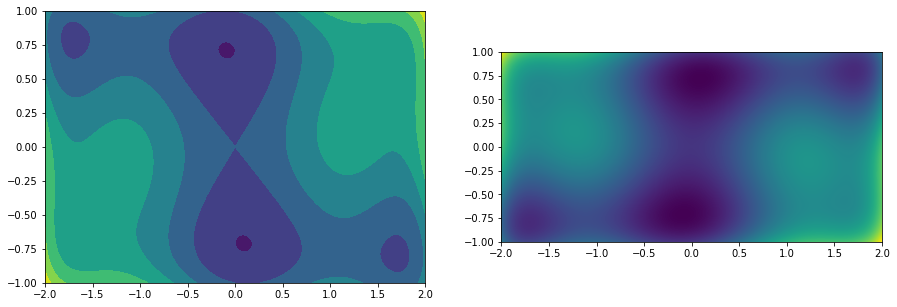

In [42]:
epsilon = 0.01
x = np.arange(-2, 2+epsilon, epsilon)
y = np.arange(-1, 1+epsilon, epsilon)
xx, yy = np.meshgrid(x, y, sparse=True)
coord = [xx, yy]

def f(X):
    return ((4-(2.1*X[0]*X[0])+((X[0]**4)/3))*X[0]*X[0])+(X[0]*X[1])+(((4*X[1]*X[1])-4)*X[1]*X[1])

z = f(coord)
#print(z)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.contourf(x, y, f(coord))
ax2 = fig.add_subplot(122)
extent = (-2, 2, -1, 1)
ax2.imshow(f(coord), extent=extent)

bnds1 = ((-2, -1), (0.5, 1))
x01 = [-1.75, 0.8]
ux1 = optimize.minimize(f, x01, bounds=bnds1, constraints=None, method='CG')
print("First local minimum:\n", ux1, "\n")

bnds4 = ((1, 2), (-1, -0.5))
x04 = [1.75, -0.8]
ux4 = optimize.minimize(f, x04, bounds=bnds4, constraints=None, method='TNC')
print("Second local minimum:\n", ux4, "\n")

bnds2 = ((-0.5, 0.5), (0.5, 1))
x02 = [0, 0.75]
ux2 = optimize.minimize(f, x02, bounds=bnds2, constraints=None, method='Powell')
print("First global minimum:\n", ux2, "\n")

bnds3 = ((-0.5, 0.5), (-0.5, -1))
x03 = [0, -0.75]
ux3 = optimize.minimize(f, x03, bounds=bnds3, constraints=None, method='BFGS')
print("Second global minimum:\n", ux3, "\n")

print("From the contour plots one can see that there are two global minima and the computed function value at those points is almost the same: -1.0316284 \n")

x05 = [0, 0]
ux5 = optimize.minimize(f, x05, constraints=None, method='Nelder-Mead')
print("Result for [0, 0] as initial guess:\n", ux5, "\n")
print("For [0, 0] as initial guess, Nelder-Mead method finds the first global minimum")

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

Main statistical properties: 

Hares
max 77400.0
min 7600.0
mean 34080.95238095238
median 25400.0
std 20897.906458089667


Lynxes
max 59400.0
min 4000.0
mean 20166.666666666668
median 12300.0
std 16254.591536908763




ValueError: operands could not be broadcast together with shapes (21,) (2,) 

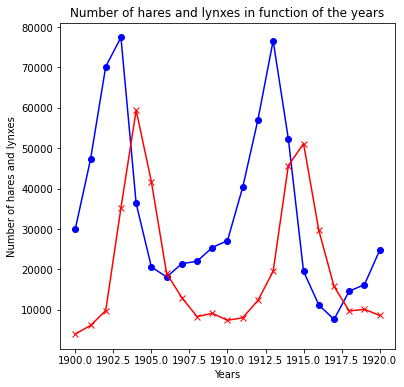

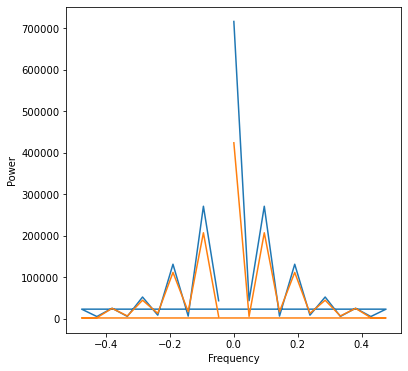

In [8]:
file_name = "/Users/Sebastiano/data/populations.txt"
data = np.loadtxt(file_name, ndmin=2)
#print("Data from datafile into 2D array: \n", data)
year = data[:, 0]
#print("Year array from datafile: \n", year)
hares = data[:, 1]
#print("Hares array from datafile: \n", hares)
lynxes = data[:, 2]
#print("Lynxes array from datafile: \n", lynxes)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('Years')
ax.set_ylabel('Number of hares and lynxes')
ax.set_title('Number of hares and lynxes in function of the years')
ax.plot(year, hares, color="blue", marker="o", linestyle="-", label='Hares')
ax.plot(year, lynxes, color="red", marker="x", linestyle="-", label='Lynxes')
#ax.legend(loc="upper right")

print("Main statistical properties: \n")
for i in range(1, 3):
    if i == 1:
        name = "Hares"
    elif i == 2:
        name = "Lynxes"
    print(name)
    for function in ['max','min','mean','median','std']:
        print(function, getattr(np, function)(data[:, i]))
    print('\n')

# The FFT of the signal
hares_fft = fftpack.fft(hares)
lynxes_fft = fftpack.fft(lynxes)

# And the power (sig_fft is of complex dtype)
hares_power = np.abs(hares_fft)
lynxes_power = np.abs(lynxes_fft)

# The corresponding frequencies
time_step = 1
hares_sample_freq = fftpack.fftfreq(hares.size, d=1)
lynxes_sample_freq = fftpack.fftfreq(lynxes.size, d=1)

# Plot the FFT power
fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.plot(hares_sample_freq, hares_power,label='Hares')
ax1.plot(lynxes_sample_freq, lynxes_power, label='Lynxes')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Power')


# Find the peak frequency: we can focus on only the positive frequencies
#hares_pos_mask = np.where(hares_sample_freq > 0)
#hares_freqs = hares_sample_freq[hares_pos_mask]
#hares_peak_freq = hares_freqs[hares_power[hares_pos_mask].argmax()]
#lynxes_pos_mask = np.where(lynxes_sample_freq > 0)
#lynxes_freqs = lynxes_sample_freq[lynxes_pos_mask]
#lynxes_peak_freq = lynxes_freqs[lynxes_power[lynxes_pos_mask].argmax()]
v = np.linspace(-0.1, 0.1, 20) #PROBLEMS
print(v)
hares_peak_freq = signal.find_peaks_cwt(hares_power, np.arange(1,10))
lynxes_peak_freq = signal.find_peaks_cwt(lynxes_power, np.arange(1,10))

# Check that it does indeed correspond to the frequency that we generate
# the signal with
#hares_period = 10
#lynxes_period = 10
#print (np.allclose(hares_peak_freq, 1./hares_period)) #risolvere problema del false
#print (np.allclose(lynxes_peak_freq, 1./lynxes_period)) #risolvere problema del false


high_freq_hares_fft = hares_fft.copy()
high_freq_hares_fft[np.abs(hares_sample_freq) > hares_peak_freq] = 0
hares_filtered_sig = fftpack.ifft(high_freq_hares_fft)
high_freq_lynxes_fft = lynxes_fft.copy()
high_freq_lynxes_fft[np.abs(lynxes_sample_freq) > lynxes_peak_freq] = 0
lynxes_filtered_sig = fftpack.ifft(high_freq_lynxes_fft)


#plt.figure(figsize=(6, 5))
#plt.plot(time_vec, sig, label='Original signal')
ax.plot(year, hares_filtered_sig, linewidth=3, label='Hares filtered signal')
ax.plot(year, lynxes_filtered_sig, linewidth=3, label='Lynxes filtered signal')
#plt.xlabel('Time [s]')
#plt.ylabel('Amplitude')
ax.legend(loc='best')

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.